# Bayesian Digressions: Bayesian Model Fitting using MCMC

From [Frequentism and Bayesianism: A Practical Introduction](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)

## The Problem: Simple Photon Counts
Imagine that we point our telescope to the sky, and observe the light coming from a single star. For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{\text{true}}$ (we'll also ignore effects like sky noise and other sources of systematic error). We'll assume that we perform a series of N measurements with our telescope, where the ith measurement reports the observed photon flux $F_i$ and error $e_i$.

The question is, given this set of measurements $D=\{F_i,e_i\}$, what is our best estimate of the true flux $F_{\text{true}}$?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 15})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from time import time
# import random
# random.seed(123)
import emcee
import corner

In [2]:
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root

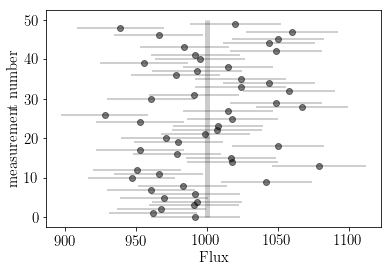

In [3]:
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");ax.set_ylabel("measurement number");

## Bayesian Approach to Simple Photon Counts
The Bayesian approach, as you might expect, begins and ends with probabilities. It recognizes that what we fundamentally want to compute is our knowledge of the parameters in question, i.e. in this case,

$$
P(F_{\text{true}} \,|\, D)
$$

Note that this formulation of the problem is fundamentally contrary to the frequentist philosophy, which says that probabilities have no meaning for model parameters like $F_{\text{true}}$. Nevertheless, within the Bayesian philosophy this is perfectly acceptable.

To compute this result, Bayesians next apply Bayes' Theorem, a fundamental law of probability:

$$
P(F_{\text{true}} \,|\, D) = \frac{P(D \,|\, F_{\text{true}}) \, P(F_{\text{true}})}{P(D)}
$$

Though Bayes' theorem is where Bayesians get their name, it is not this law itself that is controversial, but the Bayesian interpretation of probability implied by the term $P(F_{\text{true}} \,|\, D)$.

Let's take a look at each of the terms in this expression:

 - $P(F_{\text{true}} \,|\, D)$: The **posterior**, or the probability of the model parameters given the data: this is the result we want to compute.
 - $P(D \,|\, F_{\text{true}})$: The **likelihood**, which is proportional to the $\mathcal{L}(D \,|\, F_{\text{true}})$ in the frequentist approach.
 - $P(F_{\text{true}})$: The **model prior**, which encodes what we knew about the model prior to the application of the data $D$.
 - $P(D)$: The **data probability**, which in practice amounts to simply a normalization term.
 
If we set the prior $P(F_{\text{true}}) \propto 1$ (a flat prior), we find

$$
P(F_{\text{true}} \,|\, D) \propto \mathcal{L}(D \,|\, F_{\text{true}})
$$

and the Bayesian probability is maximized at precisely the same value as the frequentist result! So despite the philosophical differences, we see that (for this simple problem at least) the Bayesian and frequentist point estimates are equivalent.

Let's address how Bayesian results are generally computed in practice. For a one parameter problem like the one considered here, it's as simple as computing the posterior probability $P(F_{\rm true}~|~D)$ as a function of $F_{\rm true}$: this is the distribution reflecting our knowledge of the parameter $F_{\rm true}$. But as the dimension of the model grows, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on sampling methods such as [Markov Chain Monte Carlo (MCMC)](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).

For a practical example of applying an MCMC approach let's use Dan Foreman-Mackey's excellent [emcee](http://dan.iel.fm/emcee/current/)  package.  Keep in mind here that the goal is to *generate a set of points drawn from the posterior probability distribution*, and to use those points to determine the answer we seek.

Given a single observation $D_i = (F_i, e_i)$, we can compute the probability distribution of the measurement given the true flux $F_{\rm true}$ given our assumption of Gaussian errors:

$$ P(D_i~|~F_{\rm true}) = \frac{1}{\sqrt{2\pi e_i^2}} \exp{\left[\frac{-(F_i - F_{\rm true})^2}{2 e_i^2}\right]} $$

This should be read "the probability of $D_i$ given $F_{\rm true}$ equals ...". You should recognize this as a normal distribution with mean $F_{\rm true}$ and standard deviation $e_i$.

We construct the **likelihood function** by computing the product of the probabilities for each data point:

$$\mathcal{L}(D~|~F_{\rm true}) = \prod_{i=1}^N P(D_i~|~F_{\rm true})$$

Here $D = \{D_i\}$ represents the entire set of measurements. Because the value of the likelihood can become very small, it is often more convenient to instead compute the log-likelihood.  Combining the previous two equations and computing the log, we have

$$\log\mathcal{L} = -\frac{1}{2} \sum_{i=1}^N \left[ \log(2\pi  e_i^2) + \frac{(F_i - F_{\rm true})^2}{e_i^2} \right]$$


To perform this MCMC, we start by defining Python functions for the prior $P(F_{\rm true})$, the likelihood $P(D~|~F_{\rm true})$, and the posterior $P(F_{\rm true}~|~D)$, noting that none of these need be properly normalized. Our model here is one-dimensional, but to handle multi-dimensional models we'll define the model in terms of an array of parameters $\theta$, which in this case is $\theta = [F_{\rm true}]$:

In [9]:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

In [11]:
log_likelihood([1], 2, 0.2)

-11.809500620770571

Now we set up the problem, including generating some random starting guesses for the multiple chains of points.

In [5]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

In [6]:
sample.shape

(50000,)

If this all worked correctly, the array `sample` should contain a series of 50000 points drawn from the posterior. Let's plot them and check:

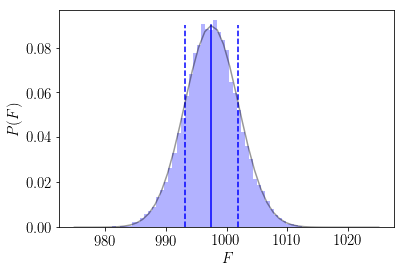

In [7]:
# plot a histogram of the sample
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, normed=True, color='b')

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

p16 = np.percentile(sample, 16)
p50 = np.percentile(sample, 50)
p84 = np.percentile(sample, 84)
y_max = 0.09
plt.plot([p16, p16], [0, y_max], 'b--')
plt.plot([p84, p84], [0, y_max], 'b--')
plt.plot([p50, p50], [0, y_max], 'b-')

plt.plot(F_fit, pdf, '-k', alpha=0.4)
plt.xlabel("$F$"); plt.ylabel("$P(F)$");

We end up with a sample of points drawn from the (normal) posterior distribution. The mean and standard deviation of this posterior are the corollary of the frequentist maximum likelihood estimate above:

In [8]:
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, np.mean(sample), np.std(sample), N))


      F_true = 1000
      F_est  = 998 +/- 4 (based on 50 measurements)
      


In [9]:
print(f'percentile 16: {p16:.2f}')
print(f'percentile 50: {p50:.2f}')
print(f'percentile 84: {p84:.2f}')
print(f'μ = {p50:.0f}')
print(f'σ = {p50-p16:.0f}')

percentile 16: 993.15
percentile 50: 997.56
percentile 84: 1002.01
μ = 998
σ = 4


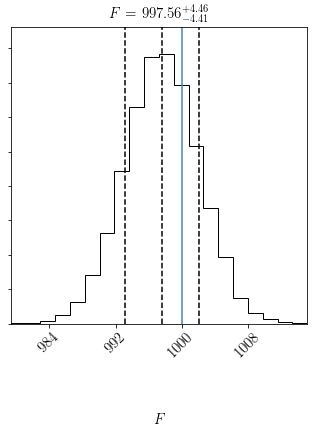

In [12]:
fig = corner.corner(sample, labels=[r'$F$'],
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[F_true],
                    show_titles=True, 
                    title_kwargs={"fontsize": 15})
fig.set_size_inches(7, 7)

## Adding a Dimension: Exploring a more sophisticated model

Let's briefly take a look at a more complicated situation, and compare the frequentist and Bayesian results yet again.  Above we assumed that the star was static: now let's assume that we're looking at an object which we suspect has some stochastic variation &mdash; that is, it varies with time, but in an unpredictable way (a Quasar is a good example of such an object).

We'll propose a simple 2-parameter Gaussian model for this object: $\theta = [\mu, \sigma]$ where $\mu$ is the mean value, and $\sigma$ is the standard deviation of the variability *intrinsic to the object*.  Thus our model for the probability of the true flux at the time of each observation looks like this:

$$ F_{\rm true} \sim \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(F - \mu)^2}{2\sigma^2}\right]$$

Now, we'll again consider $N$ observations each with their own error. We can generate them this way:

In [13]:
np.random.seed(42)  # for reproducibility
N = 100  # we'll use more samples for the more complicated model
mu_true, sigma_true = 1000, 15  # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flux
F = stats.poisson(F_true).rvs()  # observed flux: true flux plus Poisson errors.
e = np.sqrt(F)  # root-N error, as above

The resulting likelihood is the convolution of the intrinsic distribution with the error distribution, so we have

$$\mathcal{L}(D~|~\theta) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi(\sigma^2 + e_i^2)}}\exp\left[\frac{-(F_i - \mu)^2}{2(\sigma^2 + e_i^2)}\right]$$

In [14]:
def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2))
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2))

### Varying Photon Counts: The Bayesian Approach

The Bayesian approach to this problem is almost exactly the same as it was in the previous problem, and we can set it up by slightly modifying the above code.

In [15]:
def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

In [16]:
# from astroML.plotting import plot_mcmc
# fig = plt.figure()
# ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k')
# ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
# ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);

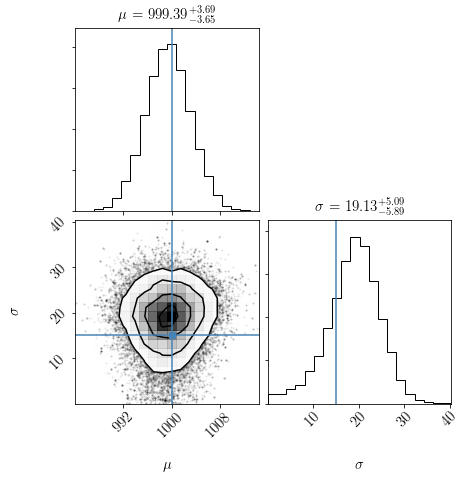

In [17]:
fig = corner.corner(sample, labels=[r'$\mu$', r'$\sigma$'],
#                     quantiles=[0.16, 0.5, 0.84],
                    truths=[mu_true, sigma_true],
                    show_titles=True, 
                    title_kwargs={"fontsize": 15})
fig.set_size_inches(7, 7)

In [18]:
sample.shape

(50000, 2)

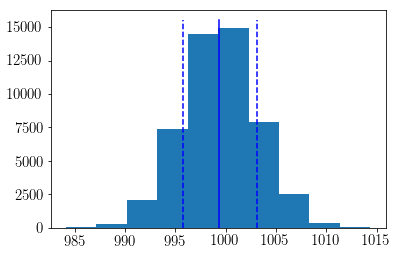

In [30]:
plt.hist(sample[:,0])

p16 = np.percentile(sample[:,0], 16)
p50 = np.percentile(sample[:,0], 50)
p84 = np.percentile(sample[:,0], 84)
y_max = 15500
plt.plot([p16, p16], [0, y_max], 'b--')
plt.plot([p84, p84], [0, y_max], 'b--')
plt.plot([p50, p50], [0, y_max], 'b-');

In [29]:
print(f'percentile 16: {p16:.2f}')
print(f'percentile 50: {p50:.2f}')
print(f'percentile 84: {p84:.2f}')
print(f'μ = {p50:.0f}')
print(f'σ- = {p50-p16:.0f}')
print(f'σ+ = {p84-p50:.0f}')

percentile 16: 995.73
percentile 50: 999.39
percentile 84: 1003.08
μ = 999
σ- = 4
σ+ = 4


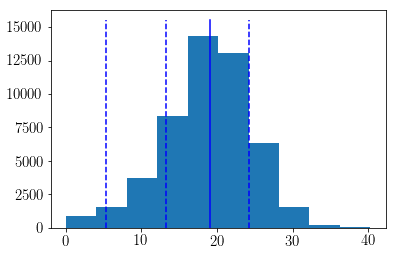

In [34]:
plt.hist(sample[:, 1])

p02 = np.percentile(sample[:,1], 2.5)
p16 = np.percentile(sample[:,1], 16)
p50 = np.percentile(sample[:,1], 50)
p84 = np.percentile(sample[:,1], 84)
y_max = 15500
plt.plot([p02, p02], [0, y_max], 'b--')
plt.plot([p16, p16], [0, y_max], 'b--')
plt.plot([p84, p84], [0, y_max], 'b--')
plt.plot([p50, p50], [0, y_max], 'b-');

In [36]:
print(f'percentile 16: {p16:.2f}')
print(f'percentile 50: {p50:.2f}')
print(f'percentile 84: {p84:.2f}')
print(f'μ = {p50:.0f}')
print(f'σ- = {p50-p16:.0f}')
print(f'σ+ = {p84-p50:.0f}')

percentile 16: 13.25
percentile 50: 19.13
percentile 84: 24.22
μ = 19
σ- = 6
σ+ = 5


In [33]:
50-95/2, 50+95/2

(2.5, 97.5)